In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import pprint
import random
import math
import seaborn as sns

import networkx as nx

### Reading data frames into dictionary

In [2]:
def reading_filenames(input_dir):
    files = [f for f in os.listdir(input_dir) if f.endswith('.tsv') or f.endswith('.txt')]

    return files

In [3]:
data_folder = 'data/wikispeedia_paths-and-graph/'
file_names = reading_filenames(data_folder)

In [4]:
dataframes = {}

#Reading files in dictionary
for file in file_names:
    try:
        if file.endswith('.tsv'):
            df = pd.read_csv(data_folder + file, sep='\t', comment='#', header = None, encoding="utf-8")
        else:
            df = pd.read_csv(data_folder + file, sep=',', comment='#', header = None, encoding="utf-8")
        
        dataframes[file.split('.')[0]] = df
    except pd.errors.ParserError as e:
        print(f"Could not parse {file}: {e}")

In [5]:
dataframes['links'] = dataframes['links'].rename(columns={0: "linkSource", 1: "linkTarget"})

In [6]:
dataframes["links"]["linkSource"] = dataframes["links"]["linkSource"].apply(unquote)
dataframes["links"]["linkTarget"] = dataframes["links"]["linkTarget"].apply(unquote)

In [7]:
dataframes['links'].head(10)

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
5,Áedán_mac_Gabráin,Isle_of_Man
6,Áedán_mac_Gabráin,Monarchy
7,Áedán_mac_Gabráin,Orkney
8,Áedán_mac_Gabráin,Picts
9,Áedán_mac_Gabráin,Scotland


In [8]:
#Renaming columns
dataframes['categories'] = dataframes['categories'].rename(columns={0: "article", 1: "category"})

In [9]:
#Decoding article names
dataframes["categories"]["article"] = dataframes["categories"]["article"].apply(unquote)

In [10]:
#Splitting categories into sub categories
split_columns = dataframes["categories"]['category'].str.split('.', expand=True)

#Dropping first column which only contains the word subject
split_columns = split_columns.drop(0, axis=1)
split_columns.head()


,1,2,3
0,History,British_History,British_History_1500_and_before_including_Roma...
1,People,Historical_figures,None
2,Countries,None,None
3,Geography,European_Geography,European_Countries
4,People,Artists,None


In [11]:
#Joining with original dataframe
dataframes["categories"] = dataframes["categories"].join(split_columns)

In [12]:
dataframes['articles'] = dataframes['articles'].rename(columns={0: "article"})
dataframes["articles"]["article"] = dataframes["articles"]["article"].apply(unquote)

In [13]:
dataframes['articles'].head(10)


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts
5,€2_commemorative_coins
6,10th_century
7,11th_century
8,12th_century
9,13th_century


In [35]:
from preprocessing import WikispeediaData
data = WikispeediaData()


In [37]:
data.categories

,article_name,1st cat,2nd cat,3rd cat
0,Áedán mac Gabráin,History,British History,British History 1500 and before including Roma...
1,Áedán mac Gabráin,People,Historical figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European Geography,European Countries
4,Édouard Manet,People,Artists,None
...,...,...,...,...
5199,Zirconium,Science,Chemistry,Chemical elements
5200,Zoroaster,People,Religious figures and leaders,None
5201,Zuid-Gelders,Geography,European Geography,None
5202,Zuid-Gelders,Language and literature,Languages,None


In [391]:
from shortest_paths import *

In [392]:
# Calculate shortest_path.csv if not already exists in 
csv_path = calculate_all_shortest_paths(data)


In [393]:
# Calculates article frequency  in all shortest paths
shortest_path_frequency = shortest_path_article_frequency(csv_path)

/home/viktor/tmp/ipykernel_11155/3831946477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shortest_path_frequency,


<function matplotlib.pyplot.show(close=None, block=None)>

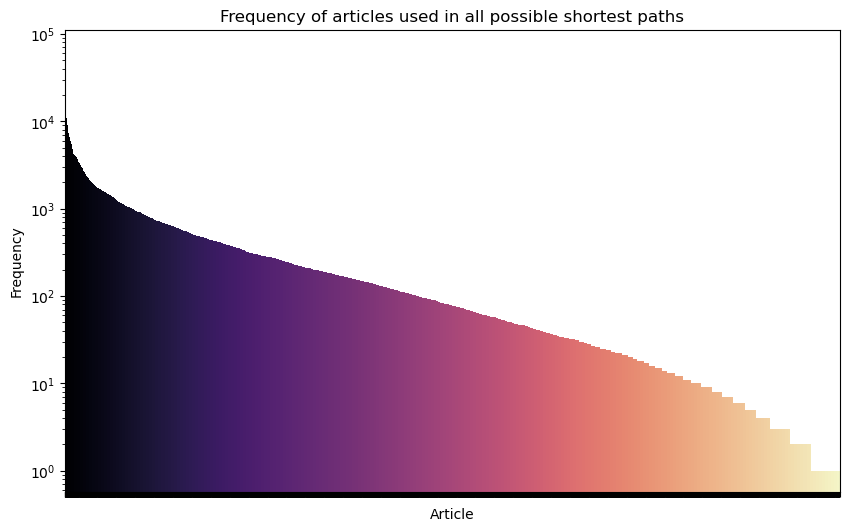

In [400]:


# Plots the frequency of articles from all shortest paths
plt.figure(figsize=(10,6))
sns.barplot(data=shortest_path_frequency,
            x ='shortest_paths',  
            y='count',
            palette='magma',
            width=1)
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.xlabel("Article")
plt.ylabel("Frequency")
plt.title('Frequency of articles used in all possible shortest paths')
plt.show


In [384]:
shortest_path_frequency

,shortest_paths,count
0,United States,64253
1,United Kingdom,29170
2,Europe,22017
3,England,18920
4,Germany,16746
...,...,...
3829,Spherical aberration,1
3830,Indian Peafowl,1
3831,Abuja,1
3832,Working poor,1


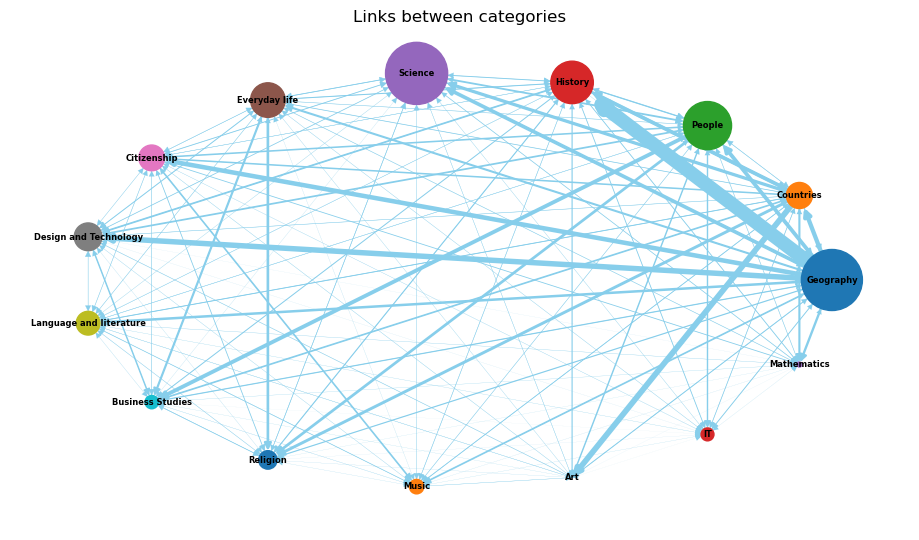

In [561]:
from sum_graph import *

sum_links_data = get_grouped_category_data(data, includeGeography=True)
create_sum_graph(data, sum_links_data)


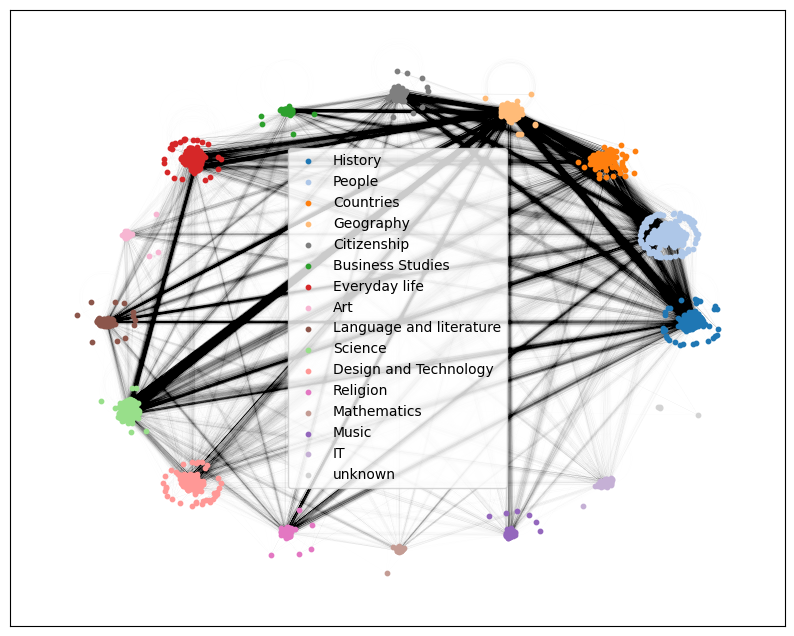

In [564]:
get_clustered_graph(data)